# 5. Binary operations, regions

Binary operations are an important class of functions to modify mask images (composed of 0's and 1's) and that are crucial when working segmenting images.

Let us first import the necessary modules:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.gray();
import skimage.io as io
from skimage.external.tifffile import TiffFile

import skimage.morphology as skm
import skimage.filters as skf

<Figure size 432x288 with 0 Axes>

And we relaod the image from the last chapter and apply some thresholding to it:

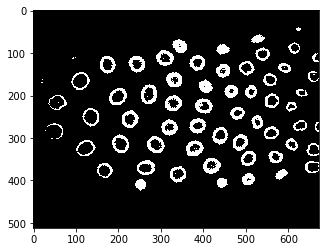

In [10]:
#load image
data = TiffFile('Data/30567/30567.tif')
image = data.pages[3].asarray()
image = skf.rank.median(image,selem=np.ones((2,2)))
image_otsu_threshold = skf.threshold_otsu(image)
image_otsu = image > image_otsu_threshold
plt.imshow(image_otsu);

## 5.1 Binary operations

Binary operations assign to each pixel a value depending on it's neighborhood. For example we can erode or dilate the image using an area of radius 5. Erosion: If a white pixel has a black neighbor in its region it becomes black (erode). Dilation: any black pixel which as a white neighbour becomes white:

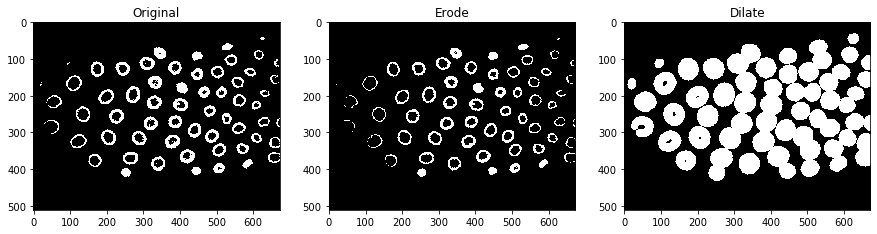

In [7]:
image_erode = skm.binary_erosion(image_otsu, selem = skm.disk(1))
image_dilate = skm.binary_dilation(image_otsu, selem = skm.disk(10))
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(image_otsu,cmap = 'gray')
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(image_erode,cmap = 'gray')
plt.title('Erode')
plt.subplot(1,3,3)
plt.imshow(image_dilate,cmap = 'gray')
plt.title('Dilate');

If one is only interested in the path of those shapes, one can also thin them to the maximum:

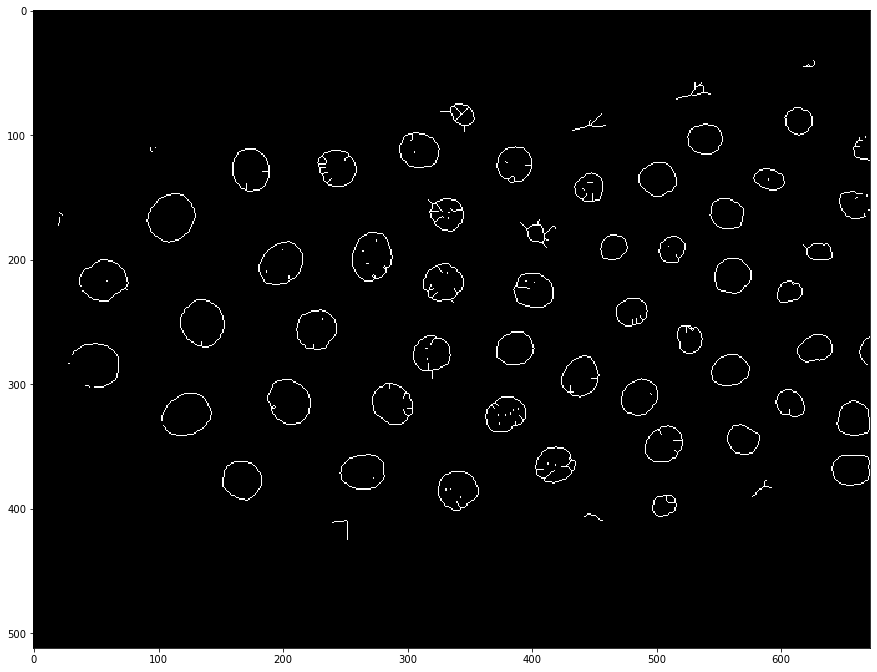

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(skm.skeletonize(image_otsu));

Those operations can also be combined to "clean-up" an image. For example one can first erode the image to suppress isoltated pixels, and then dilate it again to restore larger structures to their original size. After that, the thinning operation gives a better result:

In [14]:
image_open = skm.binary_opening(image_otsu, selem = skm.disk(2))
image_thin = skm.skeletonize(image_open)

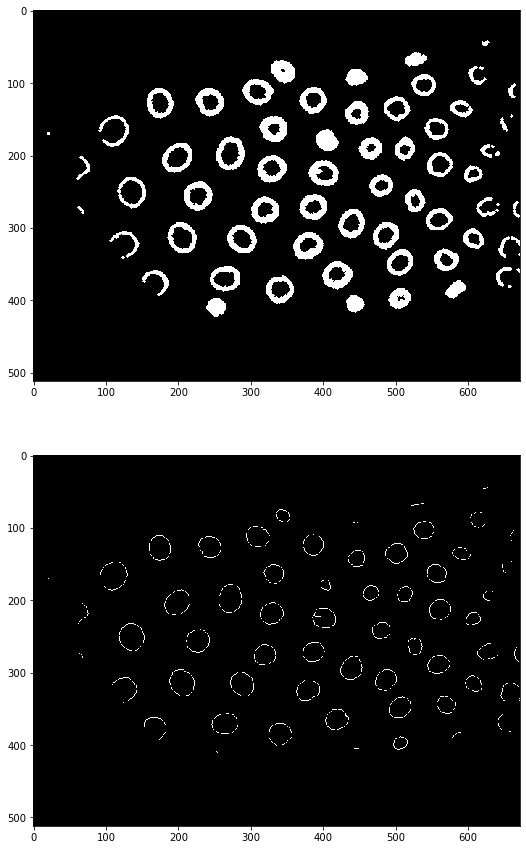

In [20]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.imshow(image_open)
plt.subplot(2,1,2)
plt.imshow(image_thin);

The result of the segmentation is ok but we still have nuclei which are broken or not clean. Let's see if we can achieve a better result using another tool: region properties

## 5.2 Region properties

In [21]:
from skimage.measure import label, regionprops

When using binary masks, one can make use of functions that detect all objects (connected regions) in the image and calculate a list of properties for them. Using those properties, one can filer out unwanted objects more easily.

Thanks to this additional tool, we can now use the local thresholding method which preserved better all the nuclei but generated a lot of noise:

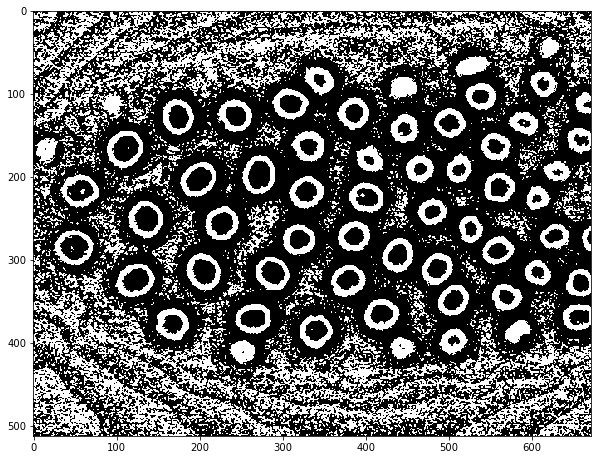

In [24]:
image_local_threshold = skf.threshold_local(image,block_size=51)
image_local = image > image_local_threshold

plt.figure(figsize=(10,10))
plt.imshow(image_local);

As the image id very noisy, there are a large number of small white regions, and applying the region functions on it will be very slow. So we first do some filtering and remove the smallest objects:

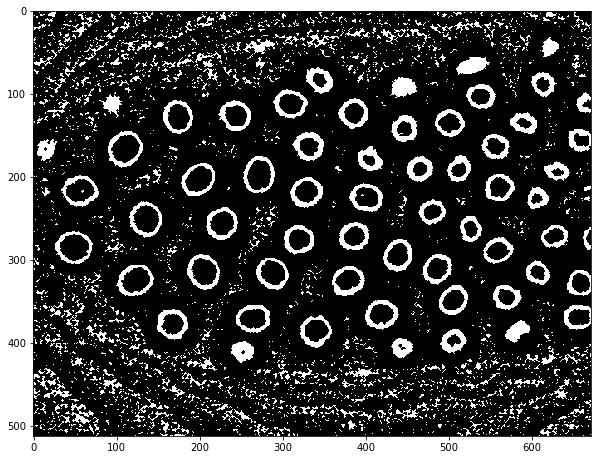

In [25]:
image_local_eroded = skm.binary_erosion(image_local, selem= skm.disk(1))

plt.figure(figsize=(10,10))
plt.imshow(image_local_eroded);

To measure the properties of each region, we need a lablled image, i.e. an image in which each individual object is attributed a number. This is achieved usin the skimage.measure.label() function. 

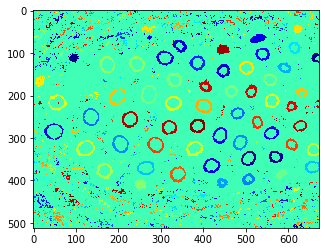

In [27]:
image_labeled = label(image_local_eroded)

#code snippet to make a random color scale
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))

plt.imshow(image_labeled,cmap = cmap);

In [28]:
image_labeled.max()

2902

And now we can measure all the objects' properties

In [29]:
our_regions = regionprops(image_labeled)
len(our_regions)

2902

We see that we have a list of 2902 regions. We can look at one of them more in detail and check what attributes exist:

In [30]:
our_regions[10]

In [31]:
dir(our_regions[10])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_cache_active',
 '_intensity_image',
 '_intensity_image_double',
 '_label_image',
 '_ndim',
 '_slice',
 'area',
 'bbox',
 'bbox_area',
 'centroid',
 'convex_area',
 'convex_image',
 'coords',
 'eccentricity',
 'equivalent_diameter',
 'euler_number',
 'extent',
 'filled_area',
 'filled_image',
 'image',
 'inertia_tensor',
 'inertia_tensor_eigvals',
 'intensity_image',
 'label',
 'local_centroid',
 'major_axis_length',
 'max_intensity',
 'mean_intensity',
 'min_intensity',
 'minor_axis_length',
 'moments',
 'moments_central',
 'moments_hu',
 'moments_normalized',
 'orientation',
 'pe

There are four types of information:
- geometric information on each shape (area, extent, perimeter, bounding box, etc.)
- vector information (pixel coordinates, centroid)
- region image information (average intensity, minimal intensity etc.)
- image-type information: the image enclosed in the bounding-box

Let us look at one region:

In [32]:
our_regions[706].area

526

In [33]:
our_regions[706].image

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

526
[[ 69 342]
 [ 69 343]
 [ 70 335]
 ...
 [ 99 350]
 [100 346]
 [100 347]]


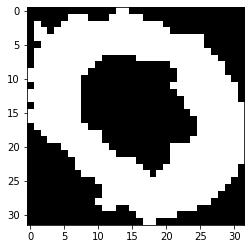

In [37]:
print(our_regions[706].area)
print(our_regions[706].coords)

plt.imshow(our_regions[706].image);


Using the coordinates information we can then for example recreate an image that contains only that region:

In [38]:
our_regions[706].coords

array([[ 69, 342],
       [ 69, 343],
       [ 70, 335],
       ...,
       [ 99, 350],
       [100, 346],
       [100, 347]])

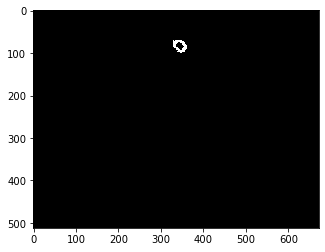

In [40]:
#create a zero image
newimage = np.zeros(image.shape)
#fill in using region coordinates
newimage[our_regions[706].coords[:,0],our_regions[706].coords[:,1]] = 1
#plot the result
plt.imshow(newimage);

In general, one has an idea about the properties of the objects that are interesting. For example, here we know that objects contain at least several tens of pixels. Let us recover all the areas and look at their distributions:

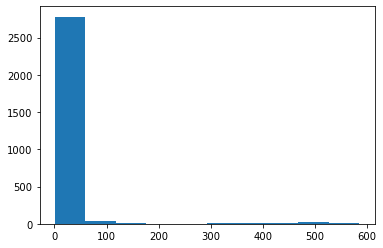

In [41]:
areas = [x.area for x in our_regions]
plt.hist(areas)
plt.show()

We see that we have a large majority of regions that are very small and that we can discard. Let's create a new image where we do that:

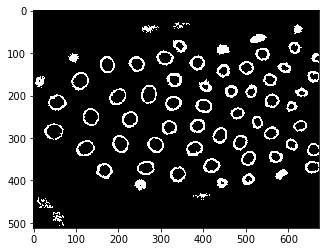

In [43]:
#create a zero image
newimage = np.zeros(image.shape)
#fill in using region coordinates
for x in our_regions:
    if x.area>200:
        newimage[x.coords[:,0],x.coords[:,1]] = 1
#plot the result
plt.imshow(newimage)

We see that we still have some spurious signal. We can measure again properties for the remaining regions and try to find another parameter for seleciton:

In [44]:
newimage_lab = label(newimage)
our_regions2 = regionprops(newimage_lab)

Most of our regions are circular, a property measures by the eccentricity. We can verifiy if we have outliers for that parameter:

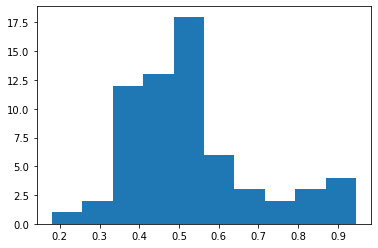

In [46]:
plt.hist([x.eccentricity for x in our_regions2]);

Let's discard regions that are too oblong (>0.8):

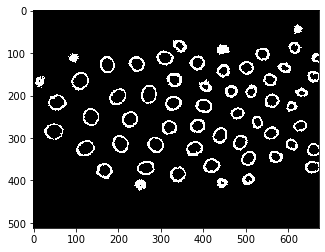

In [50]:
#create a zero image
newimage = np.zeros(image.shape)

#fill in using region coordinates
for x in our_regions2:
    if x.eccentricity<0.8:
        newimage[x.coords[:,0],x.coords[:,1]] = 1

#plot the result
plt.imshow(newimage);

This is a success! We can verify how good the segmentation is by superposing it to the image. A trick to superpose a mask on top of an image without obscuring the image, is not set all 0 elements of the mask to ```np.nan```.

In [67]:
newimage[newimage == 0] = np.nan

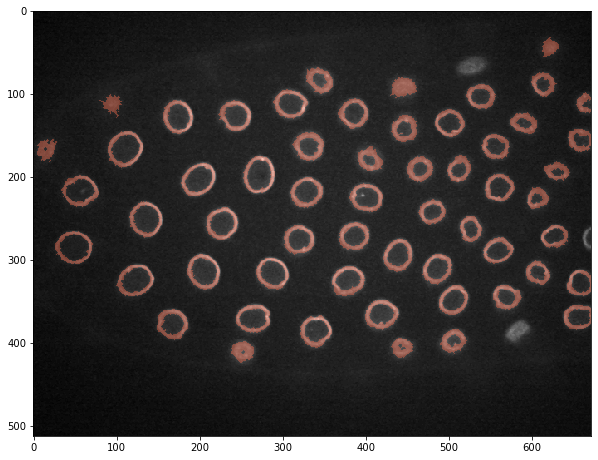

In [68]:
plt.figure(figsize=(10,10))
plt.imshow(image,cmap = 'gray')
plt.imshow(newimage,alpha = 0.4,cmap = 'Reds', vmin = 0, vmax = 2);